In [1]:
import torch
import subprocess

print("="*60)
print("GPU DIAGNOSTICS")
print("="*60)

# Check PyTorch CUDA
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version (PyTorch): {torch.version.cuda}")

# Check nvidia-smi
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    print("\nnvidia-smi output:")
    print(result.stdout)
except Exception as e:
    print(f"nvidia-smi failed: {e}")

# Check conda environment
print(f"\nPython: {subprocess.run(['which', 'python'], capture_output=True, text=True).stdout.strip()}")


GPU DIAGNOSTICS
PyTorch version: 2.9.1+cu128
CUDA available: True
CUDA version (PyTorch): 12.8

nvidia-smi output:
Sat Feb  7 16:16:45 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5090        Off |   00000000:01:00.0 Off |                  N/A |
| 38%   60C    P1            340W /  600W |    5930MiB /  32607MiB |     77%      Default |
|                        

Data Exploration and Computing Normalization Stats

4 CNN Architectures


In [8]:
%%writefile models.py
import torch
import torch.nn as nn

# ============================================================
# CNN ARCHITECTURE VARIANTS (4, 8, 16, 24 conv layers)
# ============================================================

class ConvBlock(nn.Module):
    """Basic building block: Conv3x3 -> BatchNorm -> ReLU"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


class CNN_Depth4(nn.Module):
    """4 convolutional layers - Shallow baseline"""
    def __init__(self, num_classes=1):
        super().__init__()
        
        # Block 1: 96x96 -> 48x48
        self.block1 = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d(2, 2)  # -> 48x48
        )
        
        # Block 2: 48x48 -> 24x24
        self.block2 = nn.Sequential(
            ConvBlock(32, 64),
            ConvBlock(64, 64),
            nn.MaxPool2d(2, 2)  # -> 24x24
        )
        
        # Global Average Pooling + Classifier
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class CNN_Depth8(nn.Module):
    """8 convolutional layers - Moderate depth"""
    def __init__(self, num_classes=1):
        super().__init__()
        
        # Block 1: 96x96 -> 48x48
        self.block1 = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d(2, 2)
        )
        
        # Block 2: 48x48 -> 24x24
        self.block2 = nn.Sequential(
            ConvBlock(32, 64),
            ConvBlock(64, 64),
            nn.MaxPool2d(2, 2)
        )
        
        # Block 3: 24x24 -> 12x12
        self.block3 = nn.Sequential(
            ConvBlock(64, 128),
            ConvBlock(128, 128),
            nn.MaxPool2d(2, 2)
        )
        
        # Block 4: 12x12 -> 6x6
        self.block4 = nn.Sequential(
            ConvBlock(128, 128),
            ConvBlock(128, 128),
            nn.MaxPool2d(2, 2)
        )
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class CNN_Depth16(nn.Module):
    """16 convolutional layers - Deep network"""
    def __init__(self, num_classes=1):
        super().__init__()
        
        # Block 1: 96x96 -> 48x48 (4 conv layers)
        self.block1 = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d(2, 2)
        )
        
        # Block 2: 48x48 -> 24x24 (4 conv layers)
        self.block2 = nn.Sequential(
            ConvBlock(32, 64),
            ConvBlock(64, 64),
            ConvBlock(64, 64),
            ConvBlock(64, 64),
            nn.MaxPool2d(2, 2)
        )
        
        # Block 3: 24x24 -> 12x12 (4 conv layers)
        self.block3 = nn.Sequential(
            ConvBlock(64, 128),
            ConvBlock(128, 128),
            ConvBlock(128, 128),
            ConvBlock(128, 128),
            nn.MaxPool2d(2, 2)
        )
        
        # Block 4: 12x12 -> 6x6 (4 conv layers)
        self.block4 = nn.Sequential(
            ConvBlock(128, 256),
            ConvBlock(256, 256),
            ConvBlock(256, 256),
            ConvBlock(256, 256),
            nn.MaxPool2d(2, 2)
        )
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class CNN_Depth24(nn.Module):
    """24 convolutional layers - Very deep (likely to show degradation)"""
    def __init__(self, num_classes=1):
        super().__init__()
        
        # Block 1: 96x96 -> 48x48 (6 conv layers)
        self.block1 = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d(2, 2)
        )
        
        # Block 2: 48x48 -> 24x24 (6 conv layers)
        self.block2 = nn.Sequential(
            ConvBlock(32, 64),
            ConvBlock(64, 64),
            ConvBlock(64, 64),
            ConvBlock(64, 64),
            ConvBlock(64, 64),
            ConvBlock(64, 64),
            nn.MaxPool2d(2, 2)
        )
        
        # Block 3: 24x24 -> 12x12 (6 conv layers)
        self.block3 = nn.Sequential(
            ConvBlock(64, 128),
            ConvBlock(128, 128),
            ConvBlock(128, 128),
            ConvBlock(128, 128),
            ConvBlock(128, 128),
            ConvBlock(128, 128),
            nn.MaxPool2d(2, 2)
        )
        
        # Block 4: 12x12 -> 6x6 (6 conv layers)
        self.block4 = nn.Sequential(
            ConvBlock(128, 256),
            ConvBlock(256, 256),
            ConvBlock(256, 256),
            ConvBlock(256, 256),
            ConvBlock(256, 256),
            ConvBlock(256, 256),
            nn.MaxPool2d(2, 2)
        )
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# ============================================================
# UTILITY: COUNT PARAMETERS
# ============================================================

def count_parameters(model):
    """Count trainable parameters"""
    total = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total

def print_model_summary():
    """Print summary of all architectures"""
    models = [
        ('CNN_Depth4', CNN_Depth4()),
        ('CNN_Depth8', CNN_Depth8()),
        ('CNN_Depth16', CNN_Depth16()),
        ('CNN_Depth24', CNN_Depth24()),
    ]
    
    print("="*70)
    print("MODEL ARCHITECTURE SUMMARY")
    print("="*70)
    print(f"{'Architecture':<15} {'Conv Layers':<12} {'Parameters':<15} {'Size (MB)':<12}")
    print("-"*70)
    
    for name, model in models:
        depth = int(name.split('Depth')[1])
        params = count_parameters(model)
        size_mb = params * 4 / (1024**2)  # 4 bytes per float32
        print(f"{name:<15} {depth:<12} {params:>12,} {size_mb:>11.2f}")
    
    print("="*70)
    
    # Test forward pass
    print("\nTesting forward pass with 96x96 input...")
    x = torch.randn(2, 3, 96, 96)
    for name, model in models:
        model.eval()
        with torch.no_grad():
            out = model(x)
        print(f"✓ {name}: input {tuple(x.shape)} -> output {tuple(out.shape)}")
    
    print("\n✓ All architectures validated!")

if __name__ == "__main__":
    print_model_summary()


Overwriting models.py


Multi Seed Training 

In [4]:
import os
import time
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix
)

# Import your models
from models import CNN_Depth4, CNN_Depth8, CNN_Depth16, CNN_Depth24

# ============================================================
# CONFIGURATION
# ============================================================

DATA_DIR = "/data/pcam/PatchCamelyon/data"
EXP_DIR = "/data/students/aggarwal/experiments"
os.makedirs(EXP_DIR, exist_ok=True)

TRAIN_FILES = [
    f"{DATA_DIR}/train-00000-of-00003.parquet",
    f"{DATA_DIR}/train-00001-of-00003.parquet",
    f"{DATA_DIR}/train-00002-of-00003.parquet",
]
VAL_FILES = [f"{DATA_DIR}/validation-00000-of-00001.parquet"]
TEST_FILES = [f"{DATA_DIR}/test-00000-of-00001.parquet"]

# Hyperparameters (FIXED per assignment)
BATCH_SIZE = 64
EPOCHS = 3
LR = 1e-4
WEIGHT_DECAY = 1e-4
SEEDS = [42, 43, 44, 45, 46]

# Normalization (computed from your analysis)
NORM_MEAN = [0.1821, 0.1821, 0.1821]
NORM_STD = [0.4267, 0.3903, 0.4267]

# ============================================================
# DATASET
# ============================================================

import io
from PIL import Image

def decode_pcam_image(image_dict):
    b = image_dict["bytes"]
    img = Image.open(io.BytesIO(b)).convert("RGB")
    return np.array(img, dtype=np.uint8)

class PCamParquetDataset(Dataset):
    def __init__(self, parquet_files, transform=None):
        self.files = parquet_files
        self.transform = transform
        
        self.tables = [pd.read_parquet(p) for p in self.files]
        self.offsets = []
        s = 0
        for t in self.tables:
            self.offsets.append(s)
            s += len(t)
        self.total_len = s
    
    def __len__(self):
        return self.total_len
    
    def __getitem__(self, idx):
        for table, off in zip(self.tables, self.offsets):
            if idx < off + len(table):
                row = table.iloc[idx - off]
                break
        
        img = decode_pcam_image(row["image"])
        y = float(row["label"])
        
        if self.transform:
            img = self.transform(img)
        
        return img, torch.tensor(y, dtype=torch.float32)

# ============================================================
# TRANSFORMS (with correct normalization)
# ============================================================

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),
])

# ============================================================
# TRAINING & EVALUATION FUNCTIONS
# ============================================================

def set_seed(seed):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def train_one_epoch(model, loader, optimizer, scaler, device):
    model.train()
    criterion = nn.BCEWithLogitsLoss()
    total_loss = 0.0
    n = 0
    
    for x, y in tqdm(loader, desc="Training", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).unsqueeze(1)
        
        optimizer.zero_grad(set_to_none=True)
        
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            logits = model(x)
            loss = criterion(logits, y)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += float(loss) * x.size(0)
        n += x.size(0)
    
    return total_loss / n

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    criterion = nn.BCEWithLogitsLoss()
    
    all_y = []
    all_probs = []
    total_loss = 0.0
    n = 0
    
    for x, y in tqdm(loader, desc="Evaluating", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).unsqueeze(1)
        
        logits = model(x)
        loss = criterion(logits, y)
        
        total_loss += float(loss) * x.size(0)
        n += x.size(0)
        
        probs = torch.sigmoid(logits)
        all_y.append(y.cpu().numpy().reshape(-1))
        all_probs.append(probs.cpu().numpy().reshape(-1))
    
    y_true = np.concatenate(all_y)
    y_prob = np.concatenate(all_probs)
    y_pred = (y_prob >= 0.5).astype(int)
    
    metrics = {
        'loss': total_loss / n,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_prob),
    }
    
    cm = confusion_matrix(y_true, y_pred)
    return metrics, cm

# ============================================================
# MAIN TRAINING LOOP
# ============================================================

def train_model(model_class, model_name, seed, device):
    """Train a single model with given seed"""
    
    print(f"\n{'='*70}")
    print(f"Training {model_name} with seed {seed}")
    print(f"{'='*70}")
    
    # Set seed for reproducibility
    set_seed(seed)
    
    # Create datasets
    train_ds = PCamParquetDataset(TRAIN_FILES, transform=train_transform)
    val_ds = PCamParquetDataset(VAL_FILES, transform=val_transform)
    
    # Create loaders
    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=8, pin_memory=True, persistent_workers=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=8, pin_memory=True, persistent_workers=True
    )
    
    # Initialize model
    model = model_class().to(device)
    
    # Optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
    scaler = torch.amp.GradScaler("cuda")
    
    # Training logs
    history = []
    best_val_loss = float('inf')
    best_checkpoint = None
    
    # Training loop
    for epoch in range(1, EPOCHS + 1):
        t0 = time.time()
        
        train_loss = train_one_epoch(model, train_loader, optimizer, scaler, device)
        val_metrics, val_cm = evaluate(model, val_loader, device)
        
        scheduler.step()
        epoch_time = time.time() - t0
        
        # Log metrics
        log_entry = {
            'epoch': epoch,
            'time_sec': epoch_time,
            'lr': scheduler.get_last_lr()[0],
            'train_loss': train_loss,
            **{f'val_{k}': v for k, v in val_metrics.items()}
        }
        history.append(log_entry)
        
        # Print progress
        print(f"Epoch {epoch:02d}/{EPOCHS} | {epoch_time:.1f}s | "
              f"train_loss: {train_loss:.4f} | val_loss: {val_metrics['loss']:.4f} | "
              f"val_acc: {val_metrics['accuracy']:.4f} | val_auc: {val_metrics['roc_auc']:.4f}")
        
        # Save best checkpoint based on validation loss
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            best_checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'metrics': log_entry,
                'confusion_matrix': val_cm.tolist()
            }
            print(f"  → New best checkpoint (val_loss: {best_val_loss:.4f})")
    
    return history, best_checkpoint

# ============================================================
# EXPERIMENT RUNNER
# ============================================================
def experiment_exists(exp_dir):
    """Check if experiment was already completed"""
    summary_file = os.path.join(exp_dir, "summary.json")
    return os.path.exists(summary_file)

    
def run_all_experiments_resume():
    """Run remaining experiments only"""
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"\nUsing device: {device}\n")
    
    models = [
        (CNN_Depth4, "CNN_Depth4"),
        (CNN_Depth8, "CNN_Depth8"),
        (CNN_Depth16, "CNN_Depth16"),
        (CNN_Depth24, "CNN_Depth24"),
    ]
    
    all_results = []
    
    for model_class, model_name in models:
        for seed in SEEDS:  # [42, 43, 44, 45, 46]
            exp_name = f"{model_name}_seed{seed}"
            exp_dir_path = os.path.join(EXP_DIR, exp_name)
            
            # Check if already completed
            if experiment_exists(exp_dir_path):
                print(f"✓ SKIPPING {exp_name} (already completed)")
                
                # Load existing results
                with open(f"{exp_dir_path}/summary.json", 'r') as f:
                    summary = json.load(f)
                all_results.append(summary)
                continue
            
            # Train model (not yet completed)
            print(f"\n{'='*70}")
            print(f"STARTING {exp_name}")
            print(f"{'='*70}")
            
            history, best_ckpt = train_model(model_class, model_name, seed, device)
            
            # Save results
            os.makedirs(exp_dir_path, exist_ok=True)
            
            pd.DataFrame(history).to_csv(f"{exp_dir_path}/training_history.csv", index=False)
            torch.save(best_ckpt, f"{exp_dir_path}/best_model.pt")
            
            summary = {
                'model': model_name,
                'seed': seed,
                'best_epoch': best_ckpt['epoch'],
                'best_metrics': best_ckpt['metrics'],
                'confusion_matrix': best_ckpt['confusion_matrix']
            }
            
            with open(f"{exp_dir_path}/summary.json", 'w') as f:
                json.dump(summary, f, indent=2)
            
            all_results.append(summary)
            print(f"✓ Saved to {exp_dir_path}")
    
    # Save aggregated results
    pd.DataFrame(all_results).to_csv(f"{EXP_DIR}/all_results.csv", index=False)
    print(f"\n{'='*70}")
    print(f"✓ ALL EXPERIMENTS COMPLETE!")
    print(f"✓ Results saved to: {EXP_DIR}")
    print(f"{'='*70}")

if __name__ == "__main__":
    run_all_experiments_resume()



Using device: cuda

✓ SKIPPING CNN_Depth4_seed42 (already completed)
✓ SKIPPING CNN_Depth4_seed43 (already completed)
✓ SKIPPING CNN_Depth4_seed44 (already completed)
✓ SKIPPING CNN_Depth4_seed45 (already completed)
✓ SKIPPING CNN_Depth4_seed46 (already completed)
✓ SKIPPING CNN_Depth8_seed42 (already completed)
✓ SKIPPING CNN_Depth8_seed43 (already completed)
✓ SKIPPING CNN_Depth8_seed44 (already completed)
✓ SKIPPING CNN_Depth8_seed45 (already completed)
✓ SKIPPING CNN_Depth8_seed46 (already completed)
✓ SKIPPING CNN_Depth16_seed42 (already completed)
✓ SKIPPING CNN_Depth16_seed43 (already completed)
✓ SKIPPING CNN_Depth16_seed44 (already completed)
✓ SKIPPING CNN_Depth16_seed45 (already completed)
✓ SKIPPING CNN_Depth16_seed46 (already completed)
✓ SKIPPING CNN_Depth24_seed42 (already completed)
✓ SKIPPING CNN_Depth24_seed43 (already completed)

STARTING CNN_Depth24_seed44

Training CNN_Depth24 with seed 44


Epoch 01/5 | 222.9s | train_loss: 0.3354 | val_loss: 0.5006 | val_acc: 0.7928 | val_auc: 0.9206
  → New best checkpoint (val_loss: 0.5006)


Epoch 02/5 | 238.1s | train_loss: 0.2474 | val_loss: 0.3951 | val_acc: 0.8454 | val_auc: 0.9298
  → New best checkpoint (val_loss: 0.3951)


Epoch 03/5 | 215.3s | train_loss: 0.2053 | val_loss: 0.3030 | val_acc: 0.8783 | val_auc: 0.9522
  → New best checkpoint (val_loss: 0.3030)


Epoch 04/5 | 217.3s | train_loss: 0.1781 | val_loss: 0.3464 | val_acc: 0.8660 | val_auc: 0.9464


Epoch 05/5 | 203.3s | train_loss: 0.1585 | val_loss: 0.2879 | val_acc: 0.8905 | val_auc: 0.9605
  → New best checkpoint (val_loss: 0.2879)
✓ Saved to /data/students/aggarwal/experiments/CNN_Depth24_seed44

STARTING CNN_Depth24_seed45

Training CNN_Depth24 with seed 45


Epoch 01/5 | 169.4s | train_loss: 0.3326 | val_loss: 0.5045 | val_acc: 0.7801 | val_auc: 0.9137
  → New best checkpoint (val_loss: 0.5045)


Epoch 02/5 | 164.9s | train_loss: 0.2479 | val_loss: 0.3468 | val_acc: 0.8596 | val_auc: 0.9511
  → New best checkpoint (val_loss: 0.3468)


Epoch 03/5 | 166.9s | train_loss: 0.2096 | val_loss: 0.3430 | val_acc: 0.8694 | val_auc: 0.9364
  → New best checkpoint (val_loss: 0.3430)


Epoch 04/5 | 166.0s | train_loss: 0.1826 | val_loss: 0.2704 | val_acc: 0.8867 | val_auc: 0.9615
  → New best checkpoint (val_loss: 0.2704)


Epoch 05/5 | 166.7s | train_loss: 0.1630 | val_loss: 0.3394 | val_acc: 0.8767 | val_auc: 0.9545
✓ Saved to /data/students/aggarwal/experiments/CNN_Depth24_seed45

STARTING CNN_Depth24_seed46

Training CNN_Depth24 with seed 46


Epoch 01/5 | 170.4s | train_loss: 0.3274 | val_loss: 0.3411 | val_acc: 0.8522 | val_auc: 0.9395
  → New best checkpoint (val_loss: 0.3411)


Epoch 02/5 | 207.8s | train_loss: 0.2439 | val_loss: 0.3961 | val_acc: 0.8197 | val_auc: 0.9522


Epoch 03/5 | 218.5s | train_loss: 0.2079 | val_loss: 0.2713 | val_acc: 0.8934 | val_auc: 0.9616
  → New best checkpoint (val_loss: 0.2713)


Epoch 04/5 | 217.8s | train_loss: 0.1805 | val_loss: 0.2618 | val_acc: 0.8936 | val_auc: 0.9616
  → New best checkpoint (val_loss: 0.2618)


Epoch 05/5 | 205.3s | train_loss: 0.1605 | val_loss: 0.2634 | val_acc: 0.9008 | val_auc: 0.9644
✓ Saved to /data/students/aggarwal/experiments/CNN_Depth24_seed46

✓ ALL EXPERIMENTS COMPLETE!
✓ Results saved to: /data/students/aggarwal/experiments


# Test Evaluation

In [5]:
import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)

# Import your models
from models import CNN_Depth4, CNN_Depth8, CNN_Depth16, CNN_Depth24

# Paths
DATA_DIR = "/data/pcam/PatchCamelyon/data"
EXP_DIR = "/data/students/aggarwal/experiments"
TEST_FILES = [f"{DATA_DIR}/test-00000-of-00001.parquet"]

# Normalization
NORM_MEAN = [0.1821, 0.1821, 0.1821]
NORM_STD = [0.4267, 0.3903, 0.4267]

# Test transform (no augmentation)
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),
])

# Create test dataset
test_ds = PCamParquetDataset(TEST_FILES, transform=test_transform)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False,
    num_workers=8, pin_memory=True
)

print(f"Test set size: {len(test_ds):,} samples\n")

# Model mapping
model_classes = {
    'CNN_Depth4': CNN_Depth4,
    'CNN_Depth8': CNN_Depth8,
    'CNN_Depth16': CNN_Depth16,
    'CNN_Depth24': CNN_Depth24,
}

device = "cuda" if torch.cuda.is_available() else "cpu"

# Evaluate all experiments
results = []

for exp_name in sorted(os.listdir(EXP_DIR)):
    exp_path = os.path.join(EXP_DIR, exp_name)
    ckpt_path = os.path.join(exp_path, "best_model.pt")
    
    if not os.path.exists(ckpt_path):
        continue
    
    print(f"Evaluating {exp_name}...")
    
    # Parse experiment name
    model_name = '_'.join(exp_name.split('_')[:-1])  # CNN_DepthX
    seed = int(exp_name.split('_')[-1].replace('seed', ''))
    
    # Load model
    model_class = model_classes[model_name]
    model = model_class().to(device)
    
    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Evaluate on test set
    test_metrics, test_cm = evaluate(model, test_loader, device)
    
    # Store results
    results.append({
        'experiment': exp_name,
        'model': model_name,
        'seed': seed,
        'val_epoch': checkpoint['epoch'],
        'val_roc_auc': checkpoint['metrics']['val_roc_auc'],
        'val_accuracy': checkpoint['metrics']['val_accuracy'],
        'test_loss': test_metrics['loss'],
        'test_accuracy': test_metrics['accuracy'],
        'test_precision': test_metrics['precision'],
        'test_recall': test_metrics['recall'],
        'test_f1': test_metrics['f1'],
        'test_roc_auc': test_metrics['roc_auc'],
    })
    
    print(f"  Test AUC: {test_metrics['roc_auc']:.4f}")
    print(f"  Test Acc: {test_metrics['accuracy']:.4f}\n")

# Save results
df = pd.DataFrame(results)
df.to_csv(f"{EXP_DIR}/test_results.csv", index=False)

print("="*70)
print("TEST EVALUATION COMPLETE")
print("="*70)

# Compute statistics per model
summary = df.groupby('model').agg({
    'test_accuracy': ['mean', 'std'],
    'test_roc_auc': ['mean', 'std'],
    'test_precision': ['mean', 'std'],
    'test_recall': ['mean', 'std'],
    'test_f1': ['mean', 'std']
}).round(4)

print("\nPer-Model Statistics (mean ± std):")
print(summary)

summary.to_csv(f"{EXP_DIR}/test_summary_stats.csv")
print(f"\n✓ Saved: {EXP_DIR}/test_results.csv")
print(f"✓ Saved: {EXP_DIR}/test_summary_stats.csv")


Test set size: 32,768 samples

Evaluating CNN_Depth16_seed42...


  Test AUC: 0.8637
  Test Acc: 0.8062

Evaluating CNN_Depth16_seed43...


  Test AUC: 0.9021
  Test Acc: 0.8180

Evaluating CNN_Depth16_seed44...


  Test AUC: 0.9001
  Test Acc: 0.8189

Evaluating CNN_Depth16_seed45...


  Test AUC: 0.8854
  Test Acc: 0.8228

Evaluating CNN_Depth16_seed46...


  Test AUC: 0.9225
  Test Acc: 0.8501

Evaluating CNN_Depth24_seed42...


  Test AUC: 0.8641
  Test Acc: 0.8197

Evaluating CNN_Depth24_seed43...


  Test AUC: 0.9136
  Test Acc: 0.8343

Evaluating CNN_Depth24_seed44...


  Test AUC: 0.9135
  Test Acc: 0.8302

Evaluating CNN_Depth24_seed45...


  Test AUC: 0.8891
  Test Acc: 0.8162

Evaluating CNN_Depth24_seed46...


  Test AUC: 0.9402
  Test Acc: 0.8525

Evaluating CNN_Depth4_seed42...


  Test AUC: 0.8527
  Test Acc: 0.7988

Evaluating CNN_Depth4_seed43...


  Test AUC: 0.8706
  Test Acc: 0.8106

Evaluating CNN_Depth4_seed44...


  Test AUC: 0.8708
  Test Acc: 0.7997

Evaluating CNN_Depth4_seed45...


  Test AUC: 0.8728
  Test Acc: 0.8220

Evaluating CNN_Depth4_seed46...


  Test AUC: 0.8844
  Test Acc: 0.8085

Evaluating CNN_Depth8_seed42...


  Test AUC: 0.8950
  Test Acc: 0.8205

Evaluating CNN_Depth8_seed43...


  Test AUC: 0.9033
  Test Acc: 0.8192

Evaluating CNN_Depth8_seed44...


  Test AUC: 0.9270
  Test Acc: 0.8304

Evaluating CNN_Depth8_seed45...


  Test AUC: 0.8929
  Test Acc: 0.7992

Evaluating CNN_Depth8_seed46...


  Test AUC: 0.8967
  Test Acc: 0.8064

TEST EVALUATION COMPLETE

Per-Model Statistics (mean ± std):
            test_accuracy         test_roc_auc         test_precision          \
                     mean     std         mean     std           mean     std   
model                                                                           
CNN_Depth16        0.8232  0.0163       0.8948  0.0218         0.9677  0.0035   
CNN_Depth24        0.8306  0.0143       0.9041  0.0287         0.9489  0.0101   
CNN_Depth4         0.8079  0.0094       0.8703  0.0113         0.9050  0.0056   
CNN_Depth8         0.8151  0.0123       0.9030  0.0140         0.9657  0.0050   

            test_recall         test_f1          
                   mean     std    mean     std  
model                                            
CNN_Depth16      0.6685  0.0325  0.7904  0.0229  
CNN_Depth24      0.6989  0.0346  0.8044  0.0207  
CNN_Depth4       0.6880  0.0241  0.7815  0.0141  
CNN_Depth8       0.6534  0.0276 

# Visualizations

✓ Saved: learning_curves.png


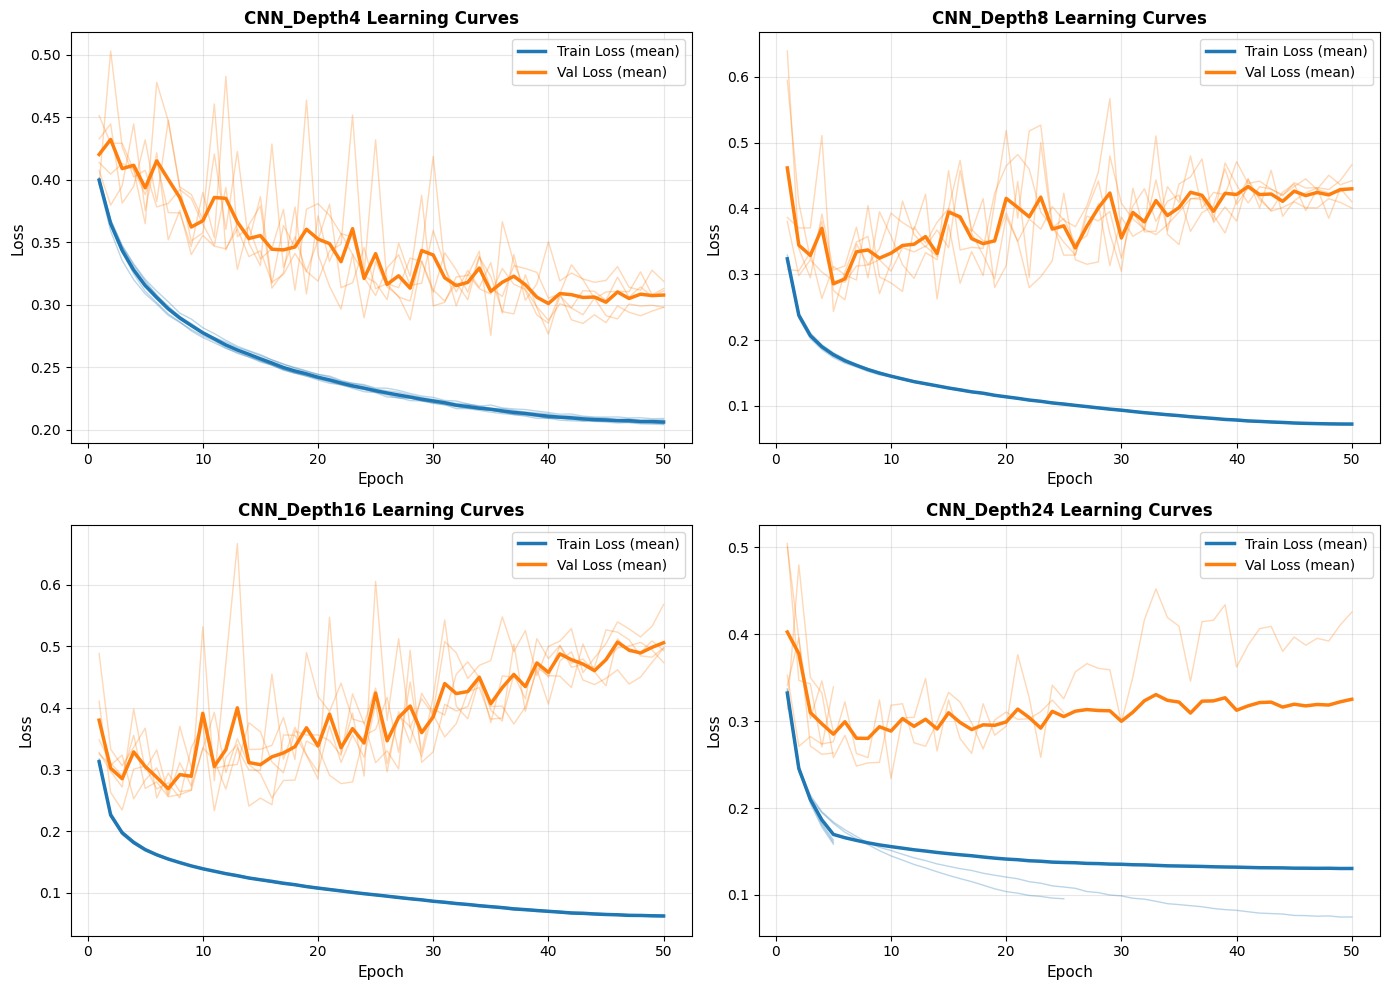

✓ Saved: params_vs_auc.png


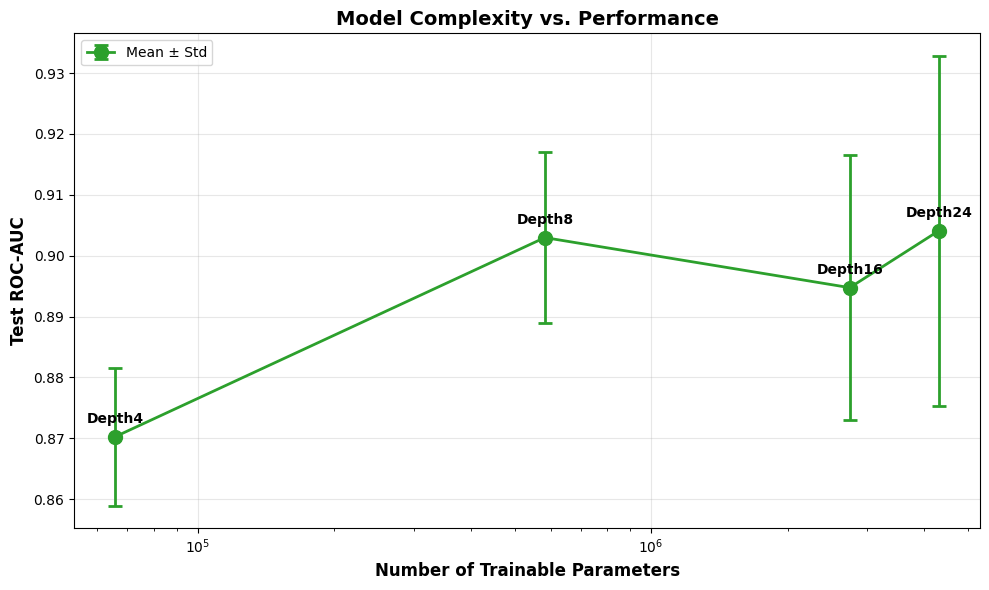

✓ Saved: boxplot_variance.png


/tmp/ipykernel_423437/4043194220.py:164: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, positions=positions, labels=labels,


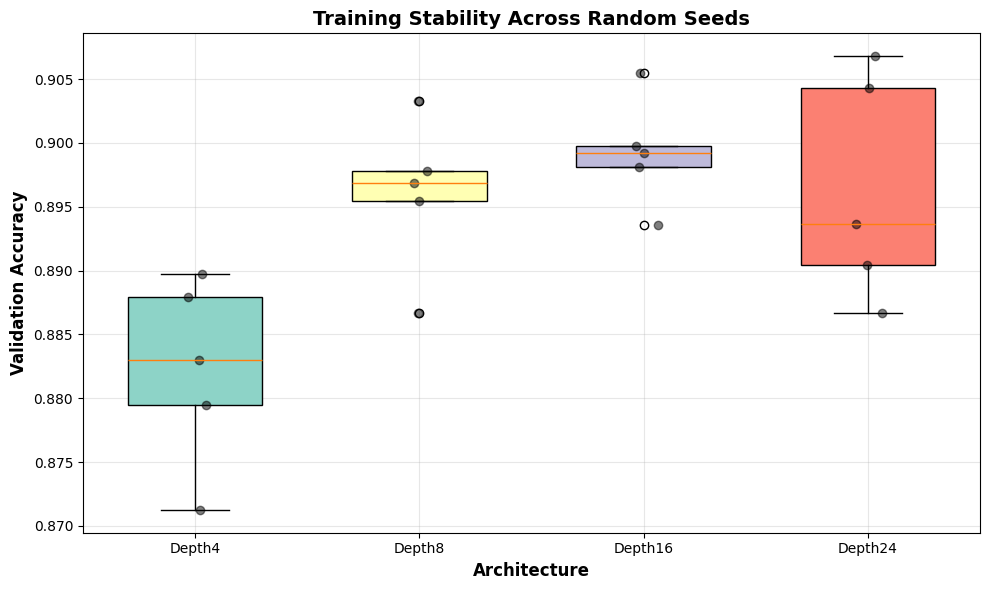

✓ Saved: confusion_matrices.png


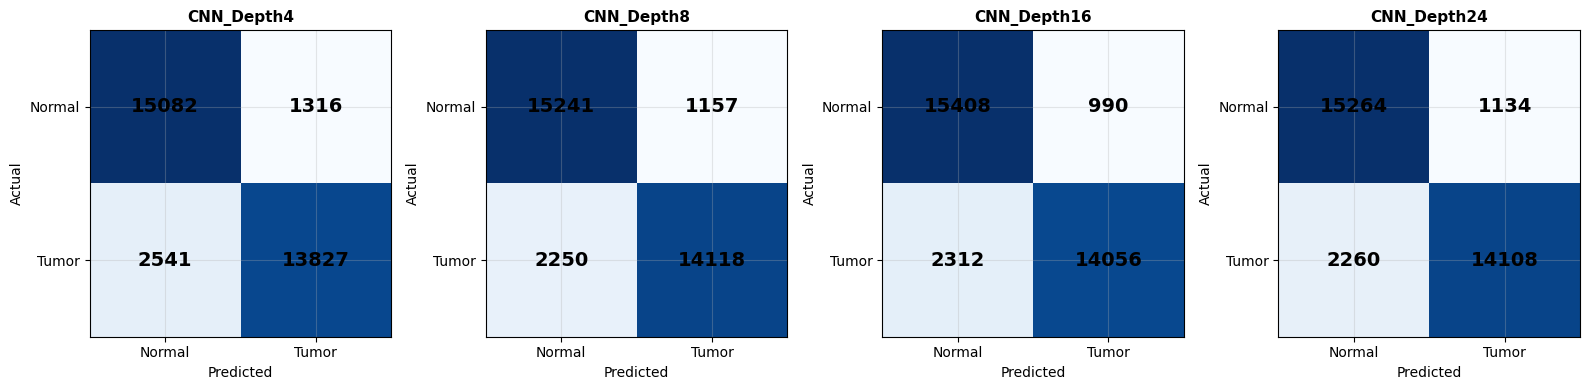


✅ ALL VISUALIZATIONS COMPLETE

Generated files:
  • learning_curves.png
  • params_vs_auc.png
  • boxplot_variance.png
  • confusion_matrices.png


In [11]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set style
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

exp_dir = "/data/students/aggarwal/experiments"

# ============================================================
# PLOT 1: LEARNING CURVES (4 subplots, one per architecture)
# ============================================================

models = ['CNN_Depth4', 'CNN_Depth8', 'CNN_Depth16', 'CNN_Depth24']
seeds = [42, 43, 44, 45, 46]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, model_name in enumerate(models):
    ax = axes[idx]
    
    all_train_loss = []
    all_val_loss = []
    max_epochs = 0
    
    # First pass: find max epochs
    for seed in seeds:
        exp_name = f"{model_name}_seed{seed}"
        history_path = f"{exp_dir}/{exp_name}/training_history.csv"
        
        if os.path.exists(history_path):
            df = pd.read_csv(history_path)
            max_epochs = max(max_epochs, len(df))
    
    # Second pass: load and pad data
    for seed in seeds:
        exp_name = f"{model_name}_seed{seed}"
        history_path = f"{exp_dir}/{exp_name}/training_history.csv"
        
        if os.path.exists(history_path):
            df = pd.read_csv(history_path)
            
            # Plot individual runs (thin lines)
            ax.plot(df['epoch'], df['train_loss'], alpha=0.3, color='#1f77b4', linewidth=1)
            ax.plot(df['epoch'], df['val_loss'], alpha=0.3, color='#ff7f0e', linewidth=1)
            
            # Pad to max_epochs for averaging
            train_loss = df['train_loss'].values
            val_loss = df['val_loss'].values
            
            # Pad with last value if shorter
            if len(train_loss) < max_epochs:
                train_loss = np.pad(train_loss, (0, max_epochs - len(train_loss)), 
                                   mode='edge')
                val_loss = np.pad(val_loss, (0, max_epochs - len(val_loss)), 
                                 mode='edge')
            
            all_train_loss.append(train_loss)
            all_val_loss.append(val_loss)
    
    # Plot mean as thick line
    if all_train_loss:
        mean_train = np.mean(all_train_loss, axis=0)
        mean_val = np.mean(all_val_loss, axis=0)
        epochs = np.arange(1, len(mean_train) + 1)
        
        ax.plot(epochs, mean_train, color='#1f77b4', linewidth=2.5, label='Train Loss (mean)', zorder=10)
        ax.plot(epochs, mean_val, color='#ff7f0e', linewidth=2.5, label='Val Loss (mean)', zorder=10)
    
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Loss', fontsize=11)
    ax.set_title(f'{model_name} Learning Curves', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
print("✓ Saved: learning_curves.png")
plt.show()

# ============================================================
# PLOT 2: PARAMETERS VS TEST ROC-AUC
# ============================================================

# Load test results
test_results = pd.read_csv(f"{exp_dir}/test_results.csv")

# Compute mean AUC per model
mean_auc = test_results.groupby('model')['test_roc_auc'].mean()
std_auc = test_results.groupby('model')['test_roc_auc'].std()

# Parameter counts
param_counts = {
    'CNN_Depth4': 65825,
    'CNN_Depth8': 583009,
    'CNN_Depth16': 2742113,
    'CNN_Depth24': 4310753
}

# Prepare data
models_ordered = ['CNN_Depth4', 'CNN_Depth8', 'CNN_Depth16', 'CNN_Depth24']
params = [param_counts[m] for m in models_ordered]
aucs = [mean_auc[m] for m in models_ordered]
stds = [std_auc[m] for m in models_ordered]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot with error bars
ax.errorbar(params, aucs, yerr=stds, marker='o', markersize=10, 
            linewidth=2, capsize=5, capthick=2, color='#2ca02c', label='Mean ± Std')

# Annotate points
for i, model in enumerate(models_ordered):
    ax.annotate(model.replace('CNN_', ''), 
                (params[i], aucs[i]), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center',
                fontsize=10,
                fontweight='bold')

ax.set_xlabel('Number of Trainable Parameters', fontsize=12, fontweight='bold')
ax.set_ylabel('Test ROC-AUC', fontsize=12, fontweight='bold')
ax.set_title('Model Complexity vs. Performance', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig('params_vs_auc.png', dpi=300, bbox_inches='tight')
print("✓ Saved: params_vs_auc.png")
plt.show()

# ============================================================
# PLOT 3: BOX PLOTS OF VALIDATION ACCURACY VARIANCE
# ============================================================

# Collect validation accuracies
val_acc_by_model = {model: [] for model in models}

for model_name in models:
    for seed in seeds:
        exp_name = f"{model_name}_seed{seed}"
        summary_path = f"{exp_dir}/{exp_name}/summary.json"
        
        if os.path.exists(summary_path):
            with open(summary_path, 'r') as f:
                data = json.load(f)
            val_acc_by_model[model_name].append(data['best_metrics']['val_accuracy'])

fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for box plot
positions = np.arange(len(models))
data_to_plot = [val_acc_by_model[m] for m in models]
labels = [m.replace('CNN_', '') for m in models]

# Create box plot
bp = ax.boxplot(data_to_plot, positions=positions, labels=labels,
                patch_artist=True, widths=0.6)

# Color boxes
colors = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Add individual points
for i, (model, data) in enumerate(val_acc_by_model.items()):
    x = np.random.normal(i, 0.04, size=len(data))
    ax.plot(x, data, 'o', alpha=0.5, color='black', markersize=6)

ax.set_xlabel('Architecture', fontsize=12, fontweight='bold')
ax.set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Training Stability Across Random Seeds', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('boxplot_variance.png', dpi=300, bbox_inches='tight')
print("✓ Saved: boxplot_variance.png")
plt.show()

# ============================================================
# PLOT 4: CONFUSION MATRICES
# ============================================================

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for idx, model_name in enumerate(models):
    # Average confusion matrix across seeds
    all_cms = []
    
    for seed in seeds:
        exp_name = f"{model_name}_seed{seed}"
        summary_path = f"{exp_dir}/{exp_name}/summary.json"
        
        if os.path.exists(summary_path):
            with open(summary_path, 'r') as f:
                data = json.load(f)
            all_cms.append(np.array(data['confusion_matrix']))
    
    if all_cms:
        mean_cm = np.mean(all_cms, axis=0).astype(int)
        
        # Manual heatmap
        im = axes[idx].imshow(mean_cm, cmap='Blues', aspect='auto')
        
        # Add text annotations
        for i in range(2):
            for j in range(2):
                text = axes[idx].text(j, i, str(mean_cm[i, j]),
                                     ha="center", va="center", color="black",
                                     fontsize=14, fontweight='bold')
        
        axes[idx].set_xticks([0, 1])
        axes[idx].set_yticks([0, 1])
        axes[idx].set_xticklabels(['Normal', 'Tumor'])
        axes[idx].set_yticklabels(['Normal', 'Tumor'])
        axes[idx].set_title(f'{model_name}', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Predicted', fontsize=10)
        axes[idx].set_ylabel('Actual', fontsize=10)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
print("✓ Saved: confusion_matrices.png")
plt.show()

print("\n" + "="*70)
print("✅ ALL VISUALIZATIONS COMPLETE")
print("="*70)
print("\nGenerated files:")
print("  • learning_curves.png")
print("  • params_vs_auc.png")
print("  • boxplot_variance.png")
print("  • confusion_matrices.png")
